# 🏀 Predicción NBA 2026 — Notebook 03: Modelos de predicción de partidos

En este notebook construimos y evaluamos modelos de *Machine Learning* para predecir
los partidos de la temporada actual de la NBA, usando el dataset enriquecido
`games_2025_26_features.csv`.

Trabajaremos tres problemas principales:

1. **Clasificación**
   - Predecir si gana el equipo local: `HOME_WIN`.
   - Otros targets de clasificación derivados:
     - `BLOWOUT`: victoria por paliza (|MARGIN_HOME| ≥ 10).
     - `OVER_MEDIAN`: si el total de puntos supera la mediana histórica.
     - `OVER_P75`: si el total de puntos supera el percentil 75.

2. **Regresión**
   - `MARGIN_HOME`: margen de victoria del equipo local.
   - `TOTAL_POINTS`: puntos totales anotados en el partido.

3. **Análisis adicional**
   - Comparar la predicción de `HOME_WIN` vía clasificación directa vs.
     derivada de la regresión del margen (`MARGIN_HOME > 0`).
   - Revisar la importancia de las *features* más relevantes.

> ⚠️ **Nota importante:**
> El número de partidos jugados en la temporada actual todavía es relativamente bajo,
> por lo que los resultados pueden ser inestables. El objetivo es construir una
> **arquitectura de modelado sólida** que se pueda reentrenar a medida que haya más datos.


## 1. Carga de datos y preparación básica


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve

pd.set_option("display.max_columns", 80)

# Cargamos el dataset enriquecido
df_model = pd.read_csv("../data/processed/games_2025_26_features.csv", parse_dates=["GAME_DATE"])

df_model.head()


,GAME_ID,GAME_DATE,HOME_TEAM_ID,HOME_TEAM_ABBR,HOME_TEAM_NAME,HOME_PTS,HOME_PA,HOME_MARGIN,AWAY_TEAM_ID,AWAY_TEAM_ABBR,AWAY_TEAM_NAME,AWAY_PTS,AWAY_PA,AWAY_MARGIN,HOME_WIN,MARGIN_HOME,TOTAL_POINTS,HOME_PF_AVG_LAST5,HOME_PA_AVG_LAST5,HOME_WIN_RATE_LAST5,HOME_MARGIN_AVG_LAST5,HOME_OFF_RTG_LAST5,HOME_DEF_RTG_LAST5,HOME_NET_RTG_LAST5,HOME_PACE_LAST5,HOME_MARGIN_STD_LAST5,HOME_PACE_STD_LAST5,HOME_STREAK,HOME_REST_DAYS,AWAY_PF_AVG_LAST5,AWAY_PA_AVG_LAST5,AWAY_WIN_RATE_LAST5,AWAY_MARGIN_AVG_LAST5,AWAY_OFF_RTG_LAST5,AWAY_DEF_RTG_LAST5,AWAY_NET_RTG_LAST5,AWAY_PACE_LAST5,AWAY_MARGIN_STD_LAST5,AWAY_PACE_STD_LAST5,AWAY_STREAK,AWAY_REST_DAYS,REST_ADVANTAGE,BLOWOUT,OVER_MEDIAN,OVER_P75
0,22500002,2025-10-21,1610612747,LAL,Los Angeles Lakers,109,119,-10,1610612744,GSW,Golden State Warriors,119,109,10,0,-10,228,117.239333,117.559333,0.494857,-0.32,112.383405,112.731232,-0.347827,104.389002,13.39477,4.452629,0,1.96,117.600095,117.086952,0.508095,0.513143,112.543709,112.025836,0.517873,104.57089,13.093572,4.475017,0,1.965714,-0.005747,1,0,0
1,22500001,2025-10-21,1610612760,OKC,Oklahoma City Thunder,125,124,1,1610612745,HOU,Houston Rockets,124,125,-1,1,1,249,117.239333,117.559333,0.494857,-0.32,112.383405,112.731232,-0.347827,104.389002,13.39477,4.452629,0,1.96,117.600095,117.086952,0.508095,0.513143,112.543709,112.025836,0.517873,104.57089,13.093572,4.475017,0,1.965714,-0.005747,0,1,1
2,22500082,2025-10-22,1610612737,ATL,Atlanta Hawks,118,138,-20,1610612761,TOR,Toronto Raptors,138,118,20,0,-20,256,117.239333,117.559333,0.494857,-0.32,112.383405,112.731232,-0.347827,104.389002,13.39477,4.452629,0,1.96,117.600095,117.086952,0.508095,0.513143,112.543709,112.025836,0.517873,104.57089,13.093572,4.475017,0,1.965714,-0.005747,1,1,1
3,22500084,2025-10-22,1610612741,CHI,Chicago Bulls,115,111,4,1610612765,DET,Detroit Pistons,111,115,-4,1,4,226,117.239333,117.559333,0.494857,-0.32,112.383405,112.731232,-0.347827,104.389002,13.39477,4.452629,0,1.96,117.600095,117.086952,0.508095,0.513143,112.543709,112.025836,0.517873,104.57089,13.093572,4.475017,0,1.965714,-0.005747,0,0,0
4,22500086,2025-10-22,1610612749,MIL,Milwaukee Bucks,133,120,13,1610612764,WAS,Washington Wizards,120,133,-13,1,13,253,117.239333,117.559333,0.494857,-0.32,112.383405,112.731232,-0.347827,104.389002,13.39477,4.452629,0,1.96,117.600095,117.086952,0.508095,0.513143,112.543709,112.025836,0.517873,104.57089,13.093572,4.475017,0,1.965714,-0.005747,1,1,1


## 2. Definición de features, targets y split temporal

Usaremos como entrada las *features* construidas en el notebook 02:

- Forma reciente ofensiva/defensiva del local y visitante.
- PACE y su volatilidad.
- Rachas de victorias (`STREAK`).
- Días de descanso y ventaja de descanso (`REST_ADVANTAGE`).

Targets principales:

- `HOME_WIN` (clasificación).
- `MARGIN_HOME` (regresión).
- `TOTAL_POINTS` (regresión).

Targets derivados:

- `BLOWOUT` (paliza).
- `OVER_MEDIAN` y `OVER_P75` para totales de puntos.

Además, para evitar fuga temporal de información, usamos un **split temporal**:

- Primer ~80% de partidos → `train`.
- Último ~20% de partidos → `test`.


In [2]:
# Lista de features (MISMO set que definimos en el Notebook 02)
feature_cols = [
    # Forma ofensiva/defensiva LOCAL
    "HOME_PF_AVG_LAST5", "HOME_PA_AVG_LAST5",
    "HOME_WIN_RATE_LAST5", "HOME_MARGIN_AVG_LAST5",
    "HOME_OFF_RTG_LAST5", "HOME_DEF_RTG_LAST5",
    "HOME_NET_RTG_LAST5", "HOME_PACE_LAST5",
    "HOME_MARGIN_STD_LAST5", "HOME_PACE_STD_LAST5",
    # Forma ofensiva/defensiva VISITANTE
    "AWAY_PF_AVG_LAST5", "AWAY_PA_AVG_LAST5",
    "AWAY_WIN_RATE_LAST5", "AWAY_MARGIN_AVG_LAST5",
    "AWAY_OFF_RTG_LAST5", "AWAY_DEF_RTG_LAST5",
    "AWAY_NET_RTG_LAST5", "AWAY_PACE_LAST5",
    "AWAY_MARGIN_STD_LAST5", "AWAY_PACE_STD_LAST5",
    # Rachas y descanso
    "HOME_STREAK", "AWAY_STREAK",
    "HOME_REST_DAYS", "AWAY_REST_DAYS",
    "REST_ADVANTAGE",
]

# Targets
target_clf = "HOME_WIN"
target_margin = "MARGIN_HOME"
target_total = "TOTAL_POINTS"
target_blowout = "BLOWOUT"
target_over_med = "OVER_MEDIAN"
target_over_p75 = "OVER_P75"

# Orden cronológico
df_model = df_model.sort_values("GAME_DATE").reset_index(drop=True)

X = df_model[feature_cols].copy()
y_clf = df_model[target_clf].copy()
y_margin = df_model[target_margin].copy()
y_total = df_model[target_total].copy()

# Split temporal 80/20
test_size = 0.2
split_idx = int(len(df_model) * (1 - test_size))

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_clf_train    = y_clf.iloc[:split_idx]
y_clf_test     = y_clf.iloc[split_idx:]

y_margin_train = y_margin.iloc[:split_idx]
y_margin_test  = y_margin.iloc[split_idx:]

y_total_train  = y_total.iloc[:split_idx]
y_total_test   = y_total.iloc[split_idx:]

len(X_train), len(X_test)


(152, 38)

## 3. Baseline: modelos tontos de referencia

Antes de entrenar modelos de ML, construimos dos baselines:

1. **Always-home-wins:** siempre predice que el local gana.
2. **Media histórica:** para regresión del margen y puntos totales:
   - Predice siempre la media del margen de entrenamiento.
   - Predice siempre la media de los puntos totales de entrenamiento.

Esto nos da un punto de referencia mínimo: cualquier modelo de ML
debería mejorar estos baselines para considerarse útil.


In [3]:

y_baseline_clf = np.ones_like(y_clf_test)
acc_baseline = accuracy_score(y_clf_test, y_baseline_clf)

print(f"Baseline HOME siempre gana -> Accuracy: {acc_baseline:.3f}")


Baseline HOME siempre gana -> Accuracy: 0.500


In [4]:
# --- Regresión: medias históricas ---
margin_mean_train = y_margin_train.mean()
total_mean_train  = y_total_train.mean()

y_margin_baseline = np.full_like(y_margin_test, margin_mean_train)
y_total_baseline  = np.full_like(y_total_test, total_mean_train)

mae_margin_baseline = mean_absolute_error(y_margin_test, y_margin_baseline)
mae_total_baseline  = mean_absolute_error(y_total_test, y_total_baseline)

print(f"Baseline margen -> MAE: {mae_margin_baseline:.3f}")
print(f"Baseline totales -> MAE: {mae_total_baseline:.3f}")


Baseline margen -> MAE: 14.237
Baseline totales -> MAE: 17.553


## 4. Funciones auxiliares de evaluación

Definimos funciones genéricas para:

- Clasificación: accuracy, matriz de confusión, reporte, AUC, Brier score, curva de calibración.
- Regresión: MAE, RMSE y R², más gráfico real vs. predicho.


In [5]:
def eval_classification(y_true, y_pred, y_proba=None, name="Modelo"):
    print(f"=== {name} ===")
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.3f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
    plt.title(f"Matriz de confusión — {name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

    # Si tenemos probabilidades, medimos calibración básica
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            brier = brier_score_loss(y_true, y_proba)
            print(f"AUC: {auc:.3f} | Brier score: {brier:.3f}")
        except ValueError:
            print("AUC/Brier no disponibles (probablemente solo una clase en test).")

        frac_pos, mean_pred = calibration_curve(y_true, y_proba, n_bins=5)

        plt.figure(figsize=(4, 4))
        plt.plot(mean_pred, frac_pos, "o-", label="Modelo")
        plt.plot([0, 1], [0, 1], "--", label="Perfecto")
        plt.xlabel("Probabilidad predicha")
        plt.ylabel("Frecuencia real")
        plt.title(f"Curva de calibración — {name}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


In [14]:
def eval_regression(y_true, y_pred, name="Modelo"):
    # MAE normal
    mae = mean_absolute_error(y_true, y_pred)

    # En tu versión de sklearn NO podemos usar squared=False
    # Calculamos primero el MSE y luego hacemos la raíz cuadrada.
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # R^2
    r2 = r2_score(y_true, y_pred)

    print(f"{name} -> MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

    # Scatter real vs predicho
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.7)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "k--", alpha=0.7)
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.title(f"{name} — Real vs. Predicho")
    plt.grid(True, alpha=0.3)
    plt.show()


## 5. Modelo 1 — Clasificación de `HOME_WIN` con RandomForestClassifier

Empezamos con un modelo de **bosques aleatorios**:

- `n_estimators = 400`
- `max_depth = None` (árboles profundos, se controla el sobreajuste con min_samples_*).
- `min_samples_split = 4`, `min_samples_leaf = 2`
- `class_weight = 'balanced'` para compensar posibles desbalances local/visitante.

Usamos el split temporal definido anteriormente.


=== RandomForest HOME_WIN ===
Accuracy: 0.711

Classification report:
              precision    recall  f1-score   support

           0      0.786     0.579     0.667        19
           1      0.667     0.842     0.744        19

    accuracy                          0.711        38
   macro avg      0.726     0.711     0.705        38
weighted avg      0.726     0.711     0.705        38



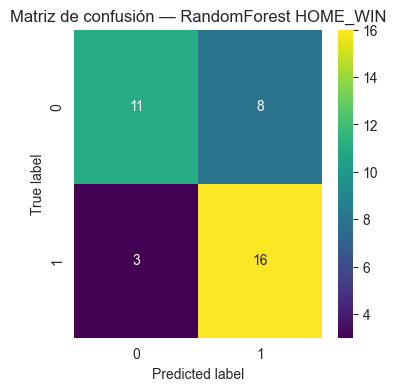

AUC: 0.873 | Brier score: 0.177


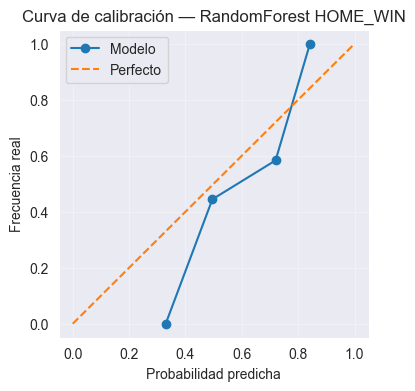

In [7]:
clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
)

clf.fit(X_train, y_clf_train)

y_clf_pred = clf.predict(X_test)
y_clf_proba = clf.predict_proba(X_test)[:, 1]

eval_classification(y_clf_test, y_clf_pred, y_clf_proba, name="RandomForest HOME_WIN")


In [9]:
y_clf_proba = clf.predict_proba(X_test)[:, 1]
y_clf_proba[:10]


array([0.68325144, 0.78586366, 0.47713565, 0.83887228, 0.38345715,
       0.49289404, 0.54884562, 0.27090539, 0.85972483, 0.36436474])

### 5.1 Importancia de features en clasificación

Visualizamos la importancia relativa de cada variable en el RandomForestClassifier.


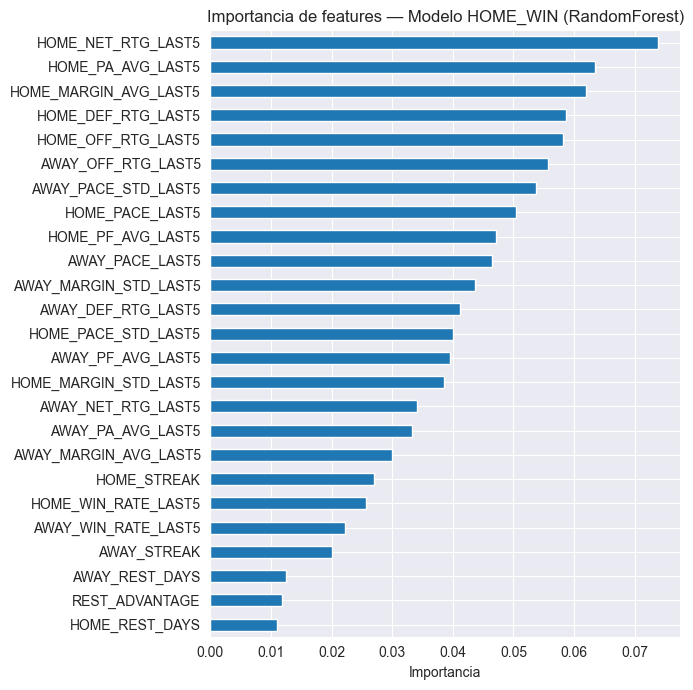

HOME_NET_RTG_LAST5       0.073793
HOME_PA_AVG_LAST5        0.063497
HOME_MARGIN_AVG_LAST5    0.061953
HOME_DEF_RTG_LAST5       0.058703
HOME_OFF_RTG_LAST5       0.058194
AWAY_OFF_RTG_LAST5       0.055677
AWAY_PACE_STD_LAST5      0.053731
HOME_PACE_LAST5          0.050441
HOME_PF_AVG_LAST5        0.047089
AWAY_PACE_LAST5          0.046423
dtype: float64

In [8]:
importances = pd.Series(clf.feature_importances_, index=feature_cols)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(7, 7))
importances.plot(kind="barh")
plt.title("Importancia de features — Modelo HOME_WIN (RandomForest)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

importances.sort_values(ascending=False).head(10)


## 6. Modelo 2 — Regresión del margen de victoria (`MARGIN_HOME`)

Ahora entrenamos un `RandomForestRegressor` para predecir directamente el margen
de puntos a favor del equipo local (`HOME_PTS - AWAY_PTS`).

Este modelo es útil para:

- Estimar cuán favorito es el equipo local.
- Derivar probabilidades de cubrir un *spread* concreto.
- Derivar también una predicción de `HOME_WIN` a partir del signo del margen.


RF MARGIN_HOME -> MAE: 10.780 | RMSE: 12.981 | R²: 0.395


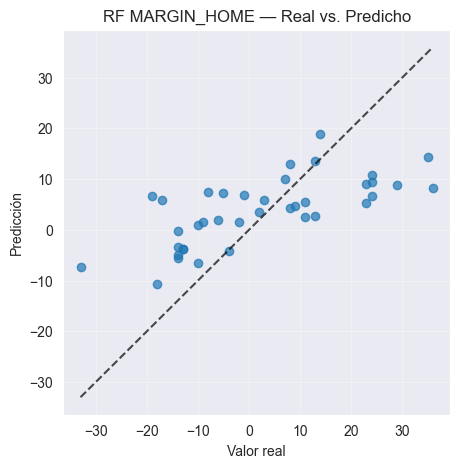

In [15]:
rf_margin = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

rf_margin.fit(X_train, y_margin_train)
y_margin_pred = rf_margin.predict(X_test)

eval_regression(y_margin_test, y_margin_pred, name="RF MARGIN_HOME")


## 7. Modelo 3 — Regresión de puntos totales (`TOTAL_POINTS`)

Entrenamos otro `RandomForestRegressor` para predecir los puntos totales anotados
en el partido (`HOME_PTS + AWAY_PTS`).

Este modelo es especialmente relevante para problemas tipo **over/under**.


RF TOTAL_POINTS -> MAE: 17.841 | RMSE: 24.286 | R²: -0.060


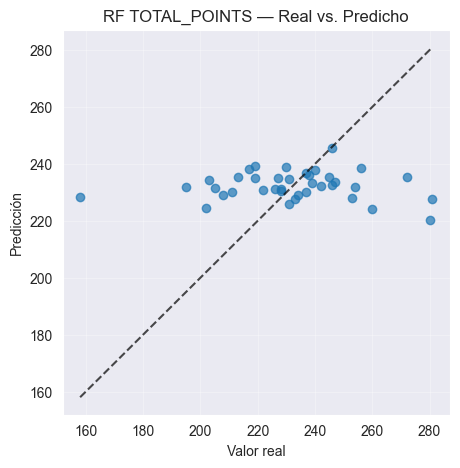

In [16]:
rf_total = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

rf_total.fit(X_train, y_total_train)
y_total_pred = rf_total.predict(X_test)

eval_regression(y_total_test, y_total_pred, name="RF TOTAL_POINTS")


## 8. Comparación: clasificación directa vs derivada de la regresión de margen

Una forma interesante de validar la coherencia del modelo es:

1. Usar el clasificador de `HOME_WIN` (RandomForestClassifier).
2. Obtener una predicción de `HOME_WIN` **a partir de la regresión de `MARGIN_HOME`**:

   - `HOME_WIN_reg` = `1` si `MARGIN_HOME_pred > 0`, si no `0`.

Comparamos accuracy de ambas y vemos si la regresión del margen
tiene sentido como fuente alternativa de predicción.


In [12]:
# Predicción de HOME_WIN derivada del margen
y_homewin_from_margin = (y_margin_pred > 0).astype(int)

acc_direct = accuracy_score(y_clf_test, y_clf_pred)
acc_from_margin = accuracy_score(y_clf_test, y_homewin_from_margin)

print(f"Accuracy clasificación directa (RF clf): {acc_direct:.3f}")
print(f"Accuracy derivada de RF margen (>0):     {acc_from_margin:.3f}")


Accuracy clasificación directa (RF clf): 0.711
Accuracy derivada de RF margen (>0):     0.763


=== HOME_WIN derivado de RF MARGIN_HOME ===
Accuracy: 0.763

Classification report:
              precision    recall  f1-score   support

           0      1.000     0.526     0.690        19
           1      0.679     1.000     0.809        19

    accuracy                          0.763        38
   macro avg      0.839     0.763     0.749        38
weighted avg      0.839     0.763     0.749        38



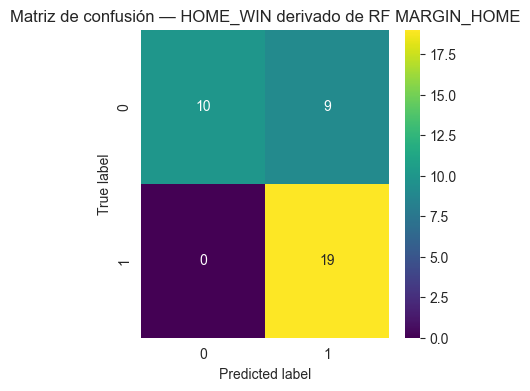

In [13]:
# Matriz de confusión para la versión derivada del margen
eval_classification(
    y_clf_test,
    y_homewin_from_margin,
    name="HOME_WIN derivado de RF MARGIN_HOME",
    y_proba=None,  # aquí no tenemos probabilidad calibrada
)


## 10. Conclusiones y próximos pasos

En este notebook:

- Construimos un pipeline completo de modelado a partir del dataset
  enriquecido de partidos (`games_2025_26_features.csv`).
- Entrenamos y comparamos:
  - Un modelo de **clasificación** para `HOME_WIN`.
  - Dos modelos de **regresión** para `MARGIN_HOME` y `TOTAL_POINTS`.
  - Clasificadores adicionales para `BLOWOUT` y `OVER_*`.
- Analizamos:
  - Rendimiento frente a baselines simples.
  - Importancia de las *features* más influyentes.
  - Coherencia entre la clasificación directa y la predicción derivada del margen.

> 🔁 **Siguiente iteración (cuando haya más datos / tiempo):**
> - Añadir tuning de hiperparámetros (RandomizedSearchCV o Optuna) respetando el orden temporal.
> - Probar modelos lineales (Ridge / LogisticRegression) para interpretar mejor coeficientes.
> - Incluir información de jugadores (stats individuales) y construir modelos a nivel jugador-partido.
> - Evaluar estabilidad del modelo reentrenándolo a medida que avanza la temporada.

Con esto dejamos una base profesional y extensible para seguir mejorando las
predicciones de la NBA durante toda la temporada. 🏀🔥
